# Data Assets

- Representation of the actual digital footprint within the organisation including accurate recommendations from DCN networks for better performance, user experience and asset management.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import hashlib
import ast
import astor
import logging
import time
import inspect
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)
from peft import PeftModel
from datasets import load_dataset

# Configure logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Reading transaction data
df = pd.read_csv(
    '../data/all_transaction_data.csv'
)

# Transforming 'quantity' and 'price' columns into 'cost' by scaling between 0 and 1
df['cost'] = (df['quantity'] * df['price']).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Aggregating interactions by grouping user, product, timestamp, city, and category, and computing sum of 'cost' and mean of 'review_score'
interactions_df = df.groupby(
    ['user_id',
     'product_id',
     'timestamp',
     'customer_city',
     'product_category']
).agg(
    {'cost': 'sum',
     'review_score': 'mean'}
).reset_index().rename(columns={'review_score': 'rating'})

# Scaling 'rating' between 0 and 1
interactions_df['rating'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

# Handling zero values in 'cost' and 'rating' by replacing them with 0.1
interactions_df['cost'] = interactions_df['cost'].replace(0, 0.1)
interactions_df['rating'] = interactions_df['rating'].replace(0, 0.1)

# Computing 'score' by multiplying 'cost' and 'rating'
interactions_df['score'] = interactions_df['cost'] * interactions_df['rating']
interactions_df.rename(columns={'product_id': 'item_id'}, inplace=True)

# Creating score percentiles and mapping scores to corresponding labels
percentiles = [0, 20, 40, 60, 80, 100]
thresholds = [interactions_df['score'].quantile(p / 100) for p in percentiles]
labels = [str(i) for i in range(1, len(percentiles))]
interactions_df['score'] = pd.cut(interactions_df['score'], bins=thresholds, labels=labels, include_lowest=True).astype(int)

# Convert timestamp into string format
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'], unit='s')
interactions_df['timestamp'] = interactions_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Combining 'timestamp' and 'user_id' columns and hashing the combined values to create 'order_id'
interactions_df['combined_values'] = interactions_df['timestamp'] + '-' + interactions_df['user_id']
interactions_df['order_id'] = interactions_df['combined_values'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest()[:32])

# Dropping the 'combined_values' column
interactions_df = interactions_df.drop(columns=['combined_values', 'cost', 'rating'])

# Splitting interactions_df into df, customer_df, and product_df
customer_df = interactions_df[['user_id', 'customer_city']].drop_duplicates().reset_index(drop=True)
product_df = interactions_df[['item_id', 'product_category']].drop_duplicates().reset_index(drop=True)
df = interactions_df.drop(columns=['customer_city', 'product_category'])

# Resetting index for customer_df, product_df, and df
customer_df.reset_index(drop=True, inplace=True)
product_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Saving dataframes to CSV files
df.to_csv('../data/df_data.csv', index=False)
customer_df.to_csv('../data/customer_df_data.csv', index=False)
product_df.to_csv('../data/product_df_data.csv', index=False)

In [2]:
# Prepare Globals
orig_df = pd.read_csv('../data/df_data.csv')
orig_customer_df = pd.read_csv('../data/customer_df_data.csv')
orig_product_df = pd.read_csv('../data/product_df_data.csv')

In [3]:
orig_df.head()

,user_id,item_id,timestamp,score,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,UNKNOWN SKU 4,2017-02-16 15:56:11,2,a8b293fba4541a7bbee981c3fab93a87
1,0000366f3b9a7992bf8c76cfdf3221e2,air_conditioning SKU 1,2018-02-25 21:50:31,2,3f1445bfa33a3a270e0a1c6170525383
2,0000366f3b9a7992bf8c76cfdf3221e2,auto SKU 1217,2017-05-19 13:27:20,5,afbe3b6ad076ea9bc293c441d28d77b1
3,0000366f3b9a7992bf8c76cfdf3221e2,auto SKU 1446,2018-01-06 13:57:08,3,0c4c43df1bd04be00299bc0d8763d27b
4,0000366f3b9a7992bf8c76cfdf3221e2,auto SKU 1524,2018-06-06 11:47:08,2,c8c018c57619b3d48800ee01d16db3bc


In [4]:
orig_customer_df.head()

,user_id,customer_city
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco
2,0000f46a3911fa3c0805444483337064,sao jose
3,0000f6ccb0745a6a4b88665a16c9f078,belem
4,0004aac84e0df4da2b147fca70cf8255,sorocaba


In [5]:
orig_product_df.head()

,item_id,product_category
0,UNKNOWN SKU 4,UNKNOWN
1,air_conditioning SKU 1,air_conditioning
2,auto SKU 1217,auto
3,auto SKU 1446,auto
4,auto SKU 1524,auto


# LLM Pre-Requisites

In [6]:
# Utility functions
def data_copy(orig_df, orig_customer_df, orig_product_df):
    """
    This function creates deep copies of the original data frames to prevent modification of the original data.

    Parameters:
    - `orig_df`: Original DataFrame containing transaction data.
    - `orig_customer_df`: Original DataFrame containing customer data.
    - `orig_product_df`: Original DataFrame containing product data.

    Returns:
    - `df`: Deep copy of the original transaction DataFrame.
    - `customer_df`: Deep copy of the original customer DataFrame.
    - `product_df`: Deep copy of the original product DataFrame.
    """
    df = orig_df.copy(deep=True)
    customer_df = orig_customer_df.copy(deep=True)
    product_df = orig_product_df.copy(deep=True)
    return df, customer_df, product_df

def create_question_context_dict(message):
    """
    Create a dictionary with question as key and context as value

    Args:
        message (list): A list containing dictionaries for question, context, and answer.

    Returns:
        dict: Dictionary of question as key and context as value
    """
    # Extracting question, context, and answer from the message
    question = message[1]['content']
    context = message[0]['content']
    answer = message[2]['content']

    return {question: context}

def parse_function_definition(definition_string):
    """
    This function parses a given function definition string and extracts important information such as function name, arguments, and body statements. It then constructs a complete function definition string by adding necessary imports and the original function definition.

    Parameters:
    - `definition_string`: The string representing the function definition.

    Returns:
    - `function_name`: Name of the parsed function.
    - `arguments`: List of arguments of the parsed function.
    - `body`: Body statements of the parsed function.
    - `function_definition`: Complete function definition string including necessary imports and the original function definition.
    """
    # Parse the definition string
    parsed = ast.parse(definition_string)
    
    # Initialize variables
    function_name = None
    arguments = []
    body = []
    
    # Iterate over parsed body
    for node in parsed.body:
        # Check if node is a function definition
        if isinstance(node, ast.FunctionDef):
            # Get function name
            function_name = node.name
            # Get function arguments
            arguments = [arg.arg for arg in node.args.args]
            
            # Iterate over function body statements
            for stmt in node.body:
                # Convert AST node to source code and append to body list
                body.append(astor.to_source(stmt).strip())
    
    # Construct complete function definition string
    function_definition = (
        "\n"
        # Import necessary modules
        f"import pandas as pd\n"
        f"import numpy as np\n"
        f"from numpy.linalg import LinAlgError\n"
        f"from datetime import datetime, timedelta\n"
        f"from collections import defaultdict, Counter\n"
        f"from itertools import combinations\n"
        f"from scipy.sparse import csr_matrix\n"
        f"from scipy.stats import zscore\n"
        f"from sklearn.preprocessing import StandardScaler, LabelEncoder\n"
        f"from sklearn.cluster import KMeans\n"
        f"from sklearn.model_selection import train_test_split\n"
        f"from sklearn.linear_model import LogisticRegression, LinearRegression\n"
        f"from sklearn.metrics.pairwise import cosine_similarity\n"
        f"from sklearn.feature_extraction.text import TfidfVectorizer\n"
        f"from sklearn.decomposition import TruncatedSVD\n"
        f"from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score\n"
        f"from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor\n"
        f"from mlxtend.frequent_patterns import apriori\n"
        f"from mlxtend.frequent_patterns import association_rules\n"
        f"from surprise import Reader, Dataset\n"
        f"from surprise.prediction_algorithms import SVD\n"
        f"from matplotlib import pyplot as plt\n"
        f"from statsmodels.tsa.statespace.sarimax import SARIMAX\n"
        f"from statsmodels.tools.sm_exceptions import ConvergenceWarning\n"
        f"from statsmodels.tsa.seasonal import seasonal_decompose\n"
        f"import warnings\n"
        f"import seaborn as sns\n"
        # Append original function definition
        f"{definition_string}"
    )
    return function_name, arguments, '\n'.join(body), function_definition

def encode_and_move_embeddings_to_gpu(query, embedder):
    """
    Encodes a query and moves the embeddings to GPU.

    Args:
        query (str): The input query to encode.
        embedder: The embedding model to use for encoding.

    Returns:
        torch.Tensor: The encoded query embeddings on GPU.
    """
    start_time = time.time()
    query_embedding = embedder.encode(query, convert_to_tensor=True).to("cuda")
    logging.info(f"\nTime for encoding and moving embeddings to GPU: {time.time() - start_time} seconds")
    return query_embedding

def normalize_embeddings(embeddings, util):
    """
    Normalizes embeddings.

    Args:
        embeddings (torch.Tensor): The embeddings to normalize.
        util: The utility object for normalization.

    Returns:
        torch.Tensor: The normalized embeddings.
    """
    start_time = time.time()
    normalized_embeddings = util.normalize_embeddings(embeddings)
    logging.info(f"\nTime for normalizing embeddings: {time.time() - start_time} seconds")
    return normalized_embeddings

def semantic_search(query_embedding, train_corpus_embeddings, util):
    """
    Performs semantic search using query embedding and train corpus embeddings.

    Args:
        query_embedding (torch.Tensor): The embedding of the query.
        train_corpus_embeddings (torch.Tensor): The embeddings of the training corpus.
        util: The utility object for semantic search.

    Returns:
        list: List of hits from the semantic search.
    """
    start_time = time.time()
    hits = util.semantic_search(query_embedding, train_corpus_embeddings, score_function=util.dot_score, top_k=1)
    logging.info(f"\nTime for semantic search: {time.time() - start_time} seconds")
    return hits

def retrieve_context(hits, train_question_context_dict, train_questions_corpus):
    """
    Retrieves context based on hits from semantic search.

    Args:
        hits (list): List of hits from semantic search.
        train_question_context_dict (dict): Dictionary mapping questions to their contexts.
        train_questions_corpus (list): List of questions in the training corpus.

    Returns:
        str: Retrieved context.
    """
    start_time = time.time()
    retrieved_context = train_question_context_dict[train_questions_corpus[hits[0][0]['corpus_id']]]
    logging.info(f"\nTime for retrieving context: {time.time() - start_time} seconds")
    return retrieved_context

def create_prompt(test_query, retrieved_context):
    """
    Creates a prompt for generating the answer.

    Args:
        test_query (str): The test query.
        retrieved_context (str): The retrieved context.

    Returns:
        str: The generated prompt.
    """
    prompt = f"""
    ### Question: {test_query}

    ### Context: {retrieved_context}
    USE ONLY DEFINED DATAFRAMES AND INCLUDE THESE AS ARGUMENTS.
    NO NEED TO CONSIDER ANY EXTERNAL DATA SOURCES, VARIABLES OR DATAFRAMES APART FROM THE ONES ALREADY AVAILABLE IN THE GLOBALS.
    THE GENERATED ANSWER SHOULD BE A SINGLE PYTHON FUNCTION WITH A `def` AND `return` ONLY.
    THE GENERATED CODE SHOULD BE COMPLETE IN ITSELF, SYNTACTICALLY CORRECT AND BE PARSED SUCCESSFULLY.
    NO NEED TO CALL THE FUNCTION OR PRINT THE FUNCTION CALL. NO NEED TO INCLUDE MAIN CALL. JUST PROVIDING THE PYTHON FUNCTION IS SUFFICIENT.
    
    ### Answer:
    """.strip()
    return prompt

def tokenize_prompt(prompt, test_tokenizer):
    """
    Tokenizes the prompt.

    Args:
        prompt (str): The prompt to tokenize.
        test_tokenizer: The tokenizer to use.

    Returns:
        dict: Model input with tokenized prompt.
    """
    start_time = time.time()
    model_input = test_tokenizer(prompt, return_tensors="pt").to("cuda")
    logging.info(f"\nTime for tokenizing prompt: {time.time() - start_time} seconds")
    return model_input

def generate_text(model_input, ft_model, eval_tokenizer):
    """
    Generates text based on model input.

    Args:
        model_input (dict): Model input with tokenized prompt.
        ft_model: The fine-tuned model for text generation.
        eval_tokenizer: The tokenizer for evaluation.

    Returns:
        torch.Tensor: Generated tokens.
    """
    start_time = time.time()
    with torch.no_grad():
        generated_tokens = ft_model.generate(
            **model_input,
            max_new_tokens=1024,
            repetition_penalty=1.15,
            pad_token_id=eval_tokenizer.eos_token_id
        )[0]
    logging.info(f"\nTime for generating text: {time.time() - start_time} seconds")
    return generated_tokens

def decode_generated_text(generated_tokens, eval_tokenizer):
    """
    Decodes generated text tokens.

    Args:
        generated_tokens (torch.Tensor): Generated tokens.
        eval_tokenizer: The tokenizer for evaluation.

    Returns:
        str: Decoded generated text.
    """
    start_time = time.time()
    generated_text = eval_tokenizer.decode(
        generated_tokens,
        skip_special_tokens=True
    )
    logging.info(f"\nTime for decoding generated text: {time.time() - start_time} seconds")
    return generated_text

def process_answer(generated_text):
    """
    Processes the generated text to extract the answer.

    Args:
        generated_text (str): The generated text.

    Returns:
        str: The processed answer.
    """
    start_time = time.time()
    start_marker = "### Answer:"
    start_index = generated_text.find(start_marker) + len(start_marker)

    if start_index == -1:
        return "No answer found."

    answer = generated_text[start_index:].strip()

    end_marker = None
    if "### Explanation:" in answer:
        end_marker = "### Explanation:"
    elif "### " in answer:
        end_marker = "### "

    if end_marker:
        end_index = answer.find(end_marker)
        if end_index != -1:
            answer = answer[:end_index].strip()

    end_of_function_index = answer.find("\r\n")
    if end_of_function_index != -1:
        answer = answer[:end_of_function_index].strip()

    end_of_function_index = answer.find("if __name__ ==")
    if end_of_function_index != -1:
        answer = answer[:end_of_function_index].strip()

    answer = answer.replace("\\\\", "\\").strip().replace("\\n", "\n").rstrip('\\').replace("\\'", "'").strip()
    logging.info(f"\nTime for processing answer string: {time.time() - start_time} seconds")
    return answer

def print_assistant_message(function_definition):
    """
    Prints a message from the assistant.

    Args:
        function_definition (str): The definition of the function.
    """
    print(f"""
    Assistant:
    {function_definition}
    """)

def execute_function(parsed_function, globals_, arguments):
    """
    Executes a parsed function.

    Args:
        parsed_function (str): The name of the function to execute.
        globals_ (dict): Global namespace dictionary.
        arguments (tuple): Arguments to pass to the function.

    Returns:
        any: Result of the executed function.
    """
    start_time = time.time()
    _parsed_function = globals_[parsed_function]
    _signature = inspect.signature(_parsed_function)
    _parameters_with_defaults = [(param.name, param.default) for param in _signature.parameters.values() if param.default != inspect.Parameter.empty]
    _default_values = dict(_parameters_with_defaults)
    _args = tuple(_default_values[arg] if arg in _default_values else globals()[arg] for arg in arguments)
    result = _parsed_function(*_args)
    logging.info(f"\nTime for executing function: {time.time() - start_time} seconds")
    return result

In [7]:
# Load training dataset
train_dataset = load_dataset('json', data_files='../data/train_CRM_data.json', split='train')

train_question_context_dict = {}

# Iterate through each example in the training dataset
for sample in train_dataset:
    
    # Extract question and context using create_question_context_dict function
    qc_pair = create_question_context_dict(sample['messages'])
    
    # Merge the extracted pairs into the train_question_context_dict
    train_question_context_dict.update(qc_pair)

# Define Mistral's pretrained model ID
base_model_id = "mistralai/Mistral-7B-v0.1"

# Define BitsAndBytesConfig for Mistral's model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                    # Load the model in 4-bit precision
    bnb_4bit_use_double_quant=True,       # Use double quantization for 4-bit quantization
    bnb_4bit_quant_type="nf4",            # Use nf4 quantization for 4-bit quantization
    bnb_4bit_compute_dtype=torch.bfloat16 # Use bfloat16 for computation with 4-bit quantization
)

# Load Mistral's pretrained model for causal language modeling
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=bnb_config, # Apply the defined quantization configuration
    device_map="auto"               # Automatically select the device for model inference
)

# Load Mistral's tokenizer
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id, 
    add_bos_token=True,     # Add beginning-of-sequence token
    trust_remote_code=True  # Trust remote code for tokenization
)

# Load the weights from the checkpoint directory
ft_model = PeftModel.from_pretrained(base_model, "../models/01-finetune-mistral/checkpoint-150")

embedder = SentenceTransformer("all-mpnet-base-v2") # best identified pre-trained model for embeddings w.r.t. semantic search

# Extracting all questions from train_question_context_dict
train_questions_corpus = list(train_question_context_dict.keys())

# Encode the training questions into embeddings and move them to GPU if available
train_corpus_embeddings = embedder.encode(
    train_questions_corpus, 
    convert_to_tensor=True
).to("cuda")

# Normalize the embeddings
train_corpus_embeddings = util.normalize_embeddings(train_corpus_embeddings)

# Init a tokenizer that doesn't add padding or eos token
test_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

# Set the fine-tuned model to evaluation mode
ft_model.eval()

INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [8]:
def get_response(user_query, mode=None):
    """
    Generate a response based on the user's query.

    Args:
    user_query (str): The user's query.

    Returns:
    result: The result of the executed function.
    """
    # Print user query for logging
    print(f"User query: {user_query}")
    
    result = None

    # Start time for measuring query execution time
    query_start_time = time.time()

    try:
        # Encode the test query into embeddings and move them to GPU if available
        query_embedding = encode_and_move_embeddings_to_gpu([user_query], embedder)

        # Normalize the embeddings
        query_embedding = normalize_embeddings(query_embedding, util)

        # Find the most similar question in the training set for the test query
        hits = semantic_search(query_embedding, train_corpus_embeddings, util)

        # Retrieve the context corresponding to the most similar question
        retrieved_context = retrieve_context(hits, train_question_context_dict, train_questions_corpus)

        # Create a prompt with the test query and the retrieved context
        prompt = create_prompt(user_query, retrieved_context)

        # Tokenize the test prompt and prepare model input for inference
        model_input = tokenize_prompt(prompt, test_tokenizer)

        # Generate text based on the model input
        generated_tokens = generate_text(model_input, ft_model, eval_tokenizer)

        # Decode the generated tokens into text, skipping special tokens
        generated_text = decode_generated_text(generated_tokens, eval_tokenizer)

        # Process the generated text to extract the answer
        answer = process_answer(generated_text)

        # Parse the function definition and retrieve function name, arguments, and complete function definition
        function_name, arguments, body, function_definition = parse_function_definition(answer)
        
        if mode == "FULL":
            print(f"\nASSISTANT:\n\n{function_definition}")

        # Execute the parsed function definition
        globals_ = {'df': df, 'customer_df': customer_df, 'product_df': product_df}
        exec(function_definition, globals_)
        result = execute_function(function_name, globals_, arguments)

    except Exception as err:
        # Log error and retry logic
        logging.error(f"Error occurred: {err}")
        print("The model ran into an error. Retrying...")

        # Retry logic
        for i in range(2):
            try:
                # Generate text for error handling
                error_prompt = f"### Question: {user_query}. Do not use {err} in your response.\n\n### Context: {retrieved_context}\n\n### Answer:"
                model_input = tokenize_prompt(error_prompt, test_tokenizer)
                generated_tokens = generate_text(model_input, ft_model, eval_tokenizer)
                generated_text = decode_generated_text(generated_tokens, eval_tokenizer)
                answer = process_answer(generated_text)

                # Parse, execute, and return result
                function_name, arguments, body, function_definition = parse_function_definition(answer)
                if mode == "FULL":
                    print(f"\nASSISTANT:\n\n{function_definition}")
                globals_ = {'df': df, 'customer_df': customer_df, 'product_df': product_df}
                exec(function_definition, globals_)
                result = execute_function(function_name, globals_, arguments)
                break
            except Exception as retry_err:
                # Log retry error
                logging.error(f"Retry error occurred: {retry_err}")
                print("The model ran into an error. Retrying...")

    # Log total execution time
    logging.info(f"Total execution time: {time.time() - query_start_time} seconds")

    return result

# Actual Execution

In [9]:
user_query = "Which is the starting date of the last week?"

# Copy original data frames
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

get_response(user_query)

User query: Which is the starting date of the last week?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:
Time for encoding and moving embeddings to GPU: 0.020400524139404297 seconds
INFO:root:
Time for normalizing embeddings: 0.0002434253692626953 seconds
INFO:root:
Time for semantic search: 0.011563539505004883 seconds
INFO:root:
Time for retrieving context: 4.5299530029296875e-06 seconds
INFO:root:
Time for tokenizing prompt: 0.0017457008361816406 seconds
2024-05-06 22:44:16.273262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 22:44:16.317068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-0

Timestamp('2024-05-01 22:44:33.512301')

In [10]:
user_query = "What is the most recommended product in sao jose?"

# Copy original data frames
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

get_response(user_query)

User query: What is the most recommended product in sao jose?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:
Time for encoding and moving embeddings to GPU: 0.017342329025268555 seconds
INFO:root:
Time for normalizing embeddings: 0.00025773048400878906 seconds
INFO:root:
Time for semantic search: 0.00028634071350097656 seconds
INFO:root:
Time for retrieving context: 3.337860107421875e-06 seconds
INFO:root:
Time for tokenizing prompt: 0.0019958019256591797 seconds
INFO:root:
Time for generating text: 22.757999420166016 seconds
INFO:root:
Time for decoding generated text: 0.000993967056274414 seconds
INFO:root:
Time for processing answer string: 1.52587890625e-05 seconds
INFO:root:
Time for executing function: 9.283386468887329 seconds
INFO:root:Total execution time: 32.06792902946472 seconds


'watches_gifts'

In [11]:
user_query = "Which customer has made the highest number of transactions?"

# Copy original data frames
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

get_response(user_query)

User query: Which customer has made the highest number of transactions?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:
Time for encoding and moving embeddings to GPU: 0.2826223373413086 seconds
INFO:root:
Time for normalizing embeddings: 0.00025963783264160156 seconds
INFO:root:
Time for semantic search: 0.00029468536376953125 seconds
INFO:root:
Time for retrieving context: 5.0067901611328125e-06 seconds
INFO:root:
Time for tokenizing prompt: 0.0027217864990234375 seconds
INFO:root:
Time for generating text: 11.029001951217651 seconds
INFO:root:
Time for decoding generated text: 0.0009272098541259766 seconds
INFO:root:
Time for processing answer string: 1.3113021850585938e-05 seconds
INFO:root:
Time for executing function: 4.005300283432007 seconds
INFO:root:Total execution time: 15.326114416122437 seconds


,user_id,score
0,0000366f3b9a7992bf8c76cfdf3221e2,3.185841


In [12]:
user_query = "Calculate the total number of orders by year and plot the trend."

# Copy original data frames
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

get_response(user_query, mode="FULL")

User query: Calculate the total number of orders by year and plot the trend.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:
Time for encoding and moving embeddings to GPU: 0.01801776885986328 seconds
INFO:root:
Time for normalizing embeddings: 0.0002346038818359375 seconds
INFO:root:
Time for semantic search: 0.0002810955047607422 seconds
INFO:root:
Time for retrieving context: 6.4373016357421875e-06 seconds
INFO:root:
Time for tokenizing prompt: 0.001226186752319336 seconds
INFO:root:
Time for generating text: 6.55596923828125 seconds
INFO:root:
Time for decoding generated text: 0.0006616115570068359 seconds
INFO:root:
Time for processing answer string: 1.0251998901367188e-05 seconds



ASSISTANT:


import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from surprise import Reader, Dataset
from surprise.prediction_algo

INFO:root:
Time for executing function: 2.4113712310791016 seconds
INFO:root:Total execution time: 8.992732763290405 seconds


,year,total_orders
0,2016,32469
1,2017,4520566
2,2018,5446926


User query: Plot the total number of orders by year.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:
Time for encoding and moving embeddings to GPU: 0.01862478256225586 seconds
INFO:root:
Time for normalizing embeddings: 0.00028014183044433594 seconds
INFO:root:
Time for semantic search: 0.0003330707550048828 seconds
INFO:root:
Time for retrieving context: 4.76837158203125e-06 seconds
INFO:root:
Time for tokenizing prompt: 0.0013742446899414062 seconds
INFO:root:
Time for generating text: 18.955355405807495 seconds
INFO:root:
Time for decoding generated text: 0.0012180805206298828 seconds
INFO:root:
Time for processing answer string: 1.1444091796875e-05 seconds



ASSISTANT:


import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from surprise import Reader, Dataset
from surprise.prediction_algo

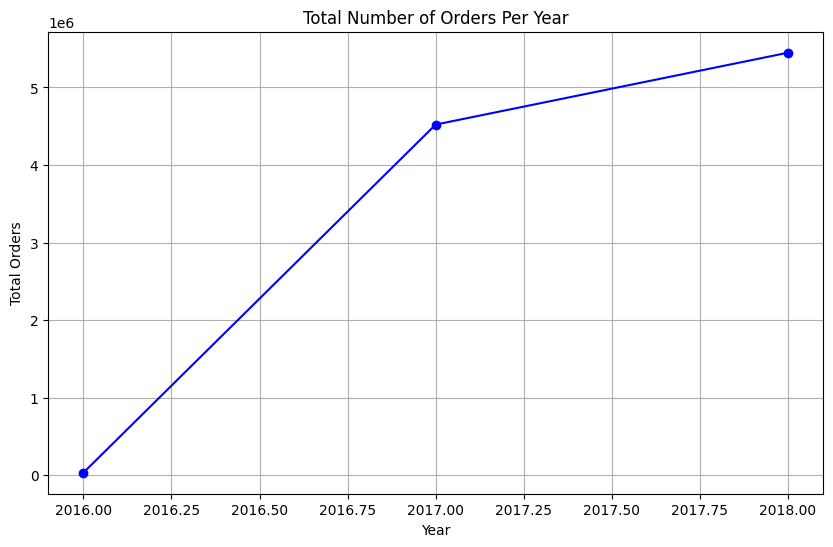

INFO:root:
Time for executing function: 2.4710421562194824 seconds
INFO:root:Total execution time: 21.453243255615234 seconds


In [13]:
user_query = "Plot the total number of orders by year."

# Copy original data frames
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

get_response(user_query, mode="FULL")